# 05 - Unsupervised Learning - Clustering
This notebook applies K-Means and Hierarchical Clustering to discover patterns in the heart disease data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

import numpy as np
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

# Load cleaned data
DATA_PATH = '../data/heart_disease.csv'
df = pd.read_csv(DATA_PATH)
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (303, 26)


,age,trestbps,chol,thalach,oldpeak,sex,fbs,exang,cp_1.0,cp_2.0,...,slope_2.0,slope_3.0,ca_0.0,ca_1.0,ca_2.0,ca_3.0,thal_3.0,thal_6.0,thal_7.0,target
0,0.948726,0.757525,-0.264900,0.017197,1.087338,0.686202,2.394438,-0.696631,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,1.392002,1.611220,0.760415,-1.821905,0.397182,0.686202,-0.417635,1.435481,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
2,1.392002,-0.665300,-0.342283,-0.902354,1.346147,0.686202,-0.417635,1.435481,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
3,-1.932564,-0.096170,0.063974,1.637359,2.122573,0.686202,-0.417635,-0.696631,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,-1.489288,-0.096170,-0.825922,0.980537,0.310912,-1.457296,-0.417635,-0.696631,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [2]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Features shape:', X.shape)
print('Target shape:', y.shape)

Features shape: (303, 25)
Target shape: (303,)


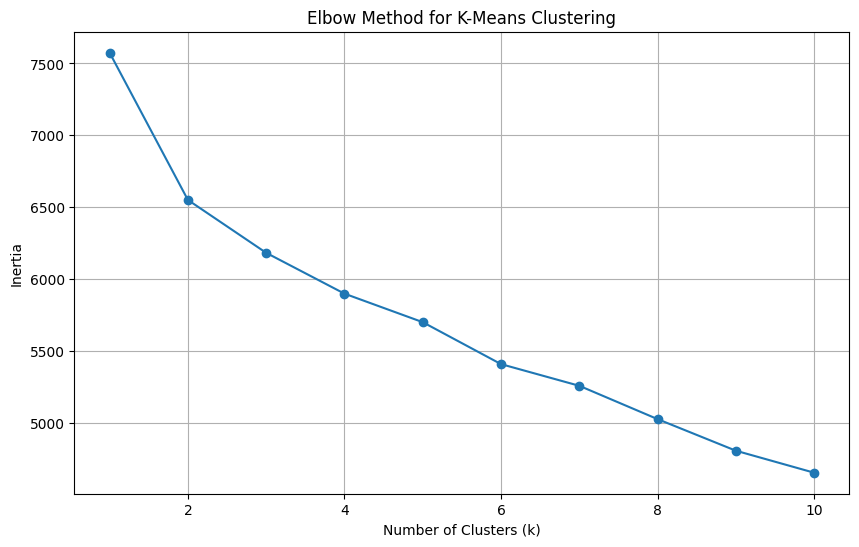

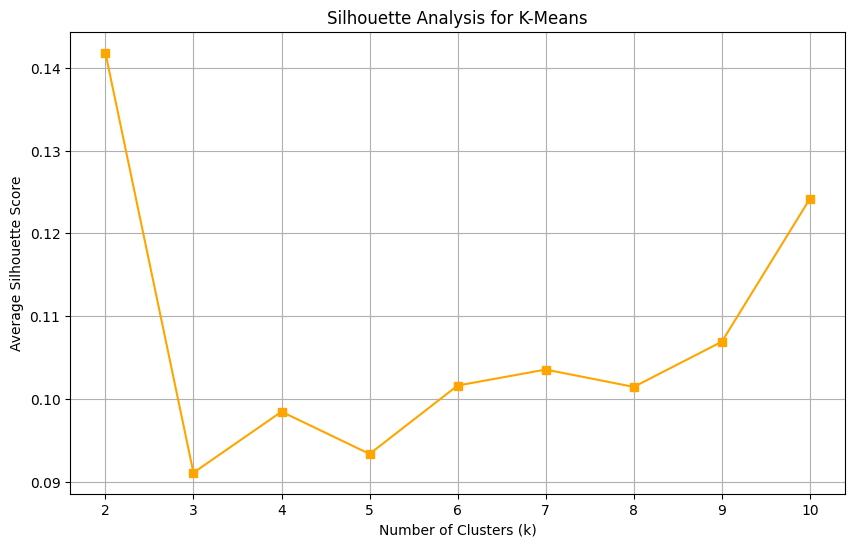

In [3]:
# 1. K-Means Clustering
# Elbow method
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means Clustering')
plt.grid(True)
plt.show()

# Silhouette Score across k=2..10
k_values = range(2, 11)
sil_scores = []
for k in k_values:
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

silhouette_best_k = list(k_values)[int(np.argmax(sil_scores))]

plt.figure(figsize=(10, 6))
plt.plot(list(k_values), sil_scores, marker='s', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis for K-Means')
plt.grid(True)
plt.show()

Cluster distribution:
0    116
2    103
1     84
Name: cluster, dtype: int64

Cluster vs Target:
target    0    1
cluster         
0        12  104
1        64   20
2        88   15


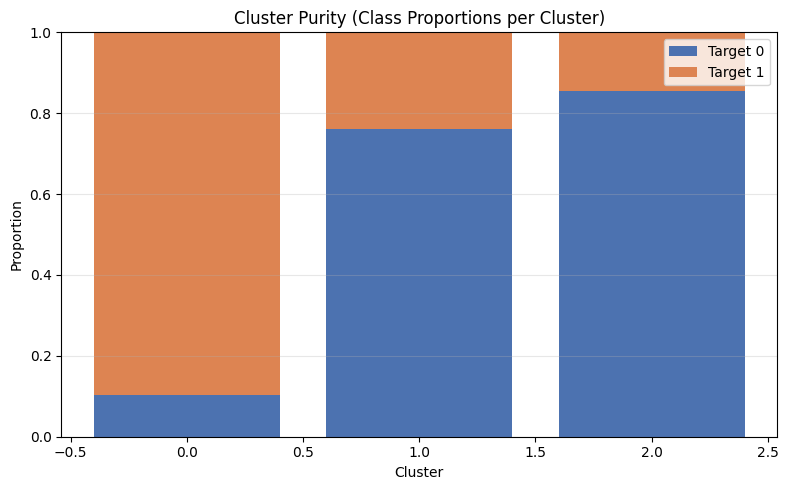

In [4]:
# Apply K-Means with optimal k
optimal_k = 3  # Based on elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters to dataframe
df['cluster'] = clusters

print('Cluster distribution:')
print(df['cluster'].value_counts())

# Compare with actual labels
crosstab = pd.crosstab(df['cluster'], df['target'])
print('\nCluster vs Target:')
print(crosstab)

# Plot cluster purity (stacked proportions of target per cluster)
purity = crosstab.div(crosstab.sum(axis=1), axis=0)
p0 = purity[0] if 0 in purity.columns else pd.Series(0, index=purity.index)
p1 = purity[1] if 1 in purity.columns else pd.Series(0, index=purity.index)
clusters_order = purity.index.tolist()
plt.figure(figsize=(8, 5))
plt.bar(clusters_order, p0, label='Target 0', color='#4C72B0')
plt.bar(clusters_order, p1, bottom=p0, label='Target 1', color='#DD8452')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.title('Cluster Purity (Class Proportions per Cluster)')
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

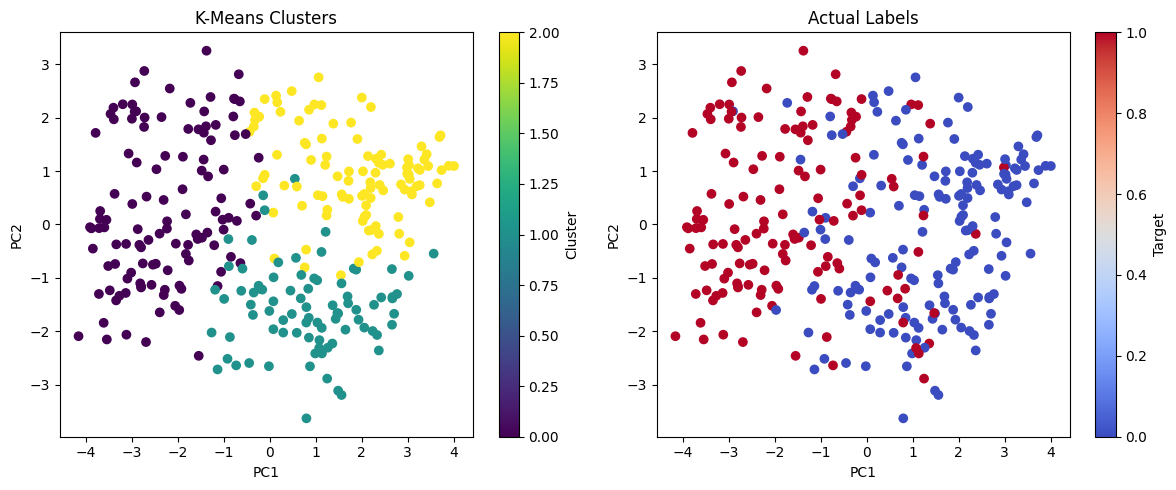

In [5]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))

# Plot 1: Clusters
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('K-Means Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')

# Plot 2: Actual labels
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm')
plt.title('Actual Labels')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Target')

plt.tight_layout()
plt.show()

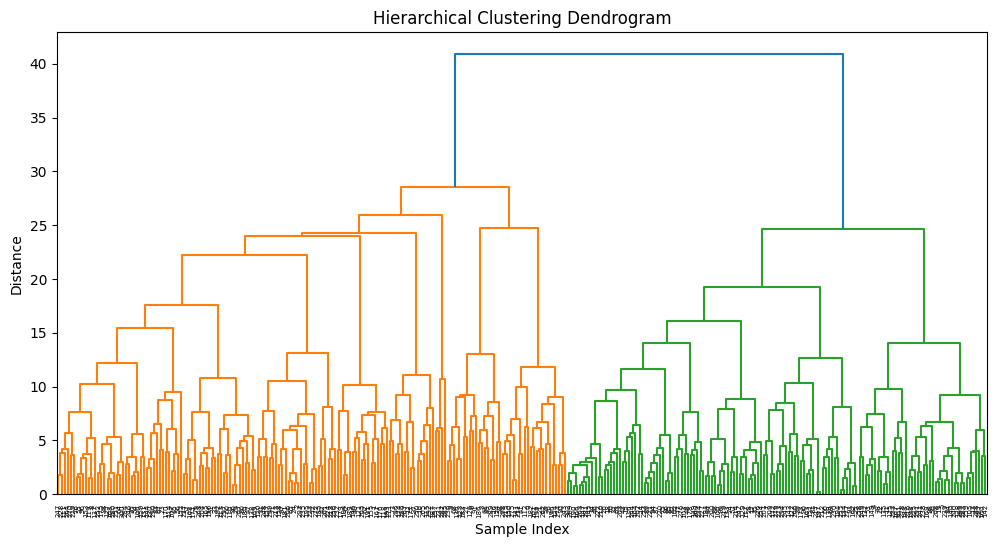

In [6]:
# 2. Hierarchical Clustering
# Create linkage matrix
linked = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=False)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [7]:
# Apply hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical_clusters = hierarchical.fit_predict(X_scaled)

# Compare with K-Means and actual labels
comparison_df = pd.DataFrame({
    'actual': y,
    'kmeans': clusters,
    'hierarchical': hierarchical_clusters
})

print('Clustering Comparison:')
print(comparison_df.groupby(['actual', 'kmeans', 'hierarchical']).size().reset_index(name='count'))

Clustering Comparison:
    actual  kmeans  hierarchical  count
0        0       0             0     11
1        0       0             2      1
2        0       1             0      5
3        0       1             1     46
4        0       1             2     13
5        0       2             0      9
6        0       2             1     71
7        0       2             2      8
8        1       0             0     88
9        1       0             1      5
10       1       0             2     11
11       1       1             0      8
12       1       1             1      9
13       1       1             2      3
14       1       2             0      6
15       1       2             1      6
16       1       2             2      3


In [8]:
# Append clustering summary to evaluation_metrics.txt
metrics_path = '../results/evaluation_metrics.txt'
os.makedirs(os.path.dirname(metrics_path), exist_ok=True)
with open(metrics_path, 'a', encoding='utf-8') as f:
    f.write('=== Unsupervised Learning Summary ===\n')
    f.write(f'K-Means chosen k: {optimal_k}\n')
    f.write(f'Silhouette best k: {silhouette_best_k}\n')
    f.write('Silhouette scores (k=2..10): ' + ', '.join([f'k={k}:{s:.3f}' for k, s in zip(k_values, sil_scores)]) + '\n')
    f.write('Cluster distribution (K-Means):\n')
    f.write(df['cluster'].value_counts().to_string())
    f.write('\n\nCluster vs Target:\n')
    f.write(pd.crosstab(df['cluster'], df['target']).to_string())
    f.write('\n\n')
print(f'Clustering summaries written to {metrics_path}')

Clustering summaries written to ../results/evaluation_metrics.txt
